# Brain Tumor Segmentation using UNet

In [5]:
import os
import glob
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.data import AUTOTUNE

In [6]:
strategy = tf.distribute.MirroredStrategy()
base_dir = '/kaggle/input/lgg-mri-segmentation/kaggle_3m'
BATCH_SIZE = 8 * 2

## Dataset

### Retrieving mask & images pairs from the dataset

In [7]:
def get_image_mask_pairs():
    """Find all image and mask pairs in the dataset"""
    pairs = []
    
    # Get all subdirectories directly
    for root, dirs, files in os.walk(base_dir):
        # Find all .tif files that don't have '_mask' in their name
        img_files = [f for f in files if f.endswith('.tif') and '_mask' not in f]
        
        for img_file in img_files:
            img_path = os.path.join(root, img_file)
            mask_file = img_file.replace('.tif', '_mask.tif')
            mask_path = os.path.join(root, mask_file)
            
            if os.path.exists(mask_path):
                pairs.append((img_path, mask_path))
    
    print(f"Found {len(pairs)} image-mask pairs")
    
    return pairs


### Process & Normalize Data 

In [8]:
def load_and_preprocess(image_path, mask_path):
    """Load and preprocess an image-mask pair using PIL for TIFF format"""
    # Convert TensorFlow tensors to Python strings
    img_path = image_path.numpy().decode('utf-8')
    msk_path = mask_path.numpy().decode('utf-8')
    
    # Open and convert images to numpy arrays
    image = np.array(Image.open(img_path))
    mask = np.array(Image.open(msk_path))
    
    # Convert grayscale images to RGB if needed
    if len(image.shape) == 2:
        image = np.stack([image, image, image], axis=-1)
    
    # Ensure mask is 2D (grayscale)
    if len(mask.shape) > 2:
        mask = mask[:, :, 0]  # Take first channel if it has multiple
    
    # Add channel dimension to mask (256, 256, 1)
    mask = mask[:, :, np.newaxis]
    
    image = tf.image.resize(image, [256, 256])
    mask = tf.image.resize(mask, [256, 256])
    
    # Normalize to [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    mask = tf.cast(mask, tf.float32) / 255.0
    
    # Return as tensors directly
    return image, mask
 


In [9]:
def create_train_val_dataset(val_split=0.2, batch_size=None):
    """Create training and validation datasets with DRY principles"""
    # Use global batch size if none provided
    if batch_size is None:
        batch_size = BATCH_SIZE
        
    # Get all pairs
    pairs = get_image_mask_pairs()
    
    # Shuffle the pairs
    np.random.shuffle(pairs)
    
    # Split into training and validation
    split_idx = int(len(pairs) * (1 - val_split))
    train_pairs = pairs[:split_idx]
    val_pairs = pairs[split_idx:]
    
    print(f"Training pairs: {len(train_pairs)}")
    print(f"Validation pairs: {len(val_pairs)}")
    
    # Helper function to create dataset from pairs
    def create_dataset_from_pairs(pairs, is_training=False):
        # Create tensors of file paths
        image_paths = tf.constant([p[0] for p in pairs])
        mask_paths = tf.constant([p[1] for p in pairs])
        
        # Create dataset
        dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
        
        # Apply shuffle for training dataset
        if is_training:
            buffer_size = min(len(pairs), 1000)
            dataset = dataset.shuffle(buffer_size, reshuffle_each_iteration=True)
        
        # Map loading function
        dataset = dataset.map(
            lambda img_path, mask_path: tf.py_function(
                func=load_and_preprocess,
                inp=[img_path, mask_path],
                Tout=[tf.float32, tf.float32]
            ),
            num_parallel_calls=AUTOTUNE
        )
        
        # Set shapes explicitly
        dataset = dataset.map(
            lambda img, mask: (
                tf.ensure_shape(img, [256, 256, 3]), 
                tf.ensure_shape(mask, [256, 256, 1])
            ),
            num_parallel_calls=AUTOTUNE
        )
        
        # Batch and prefetch
        dataset = dataset.batch(batch_size, drop_remainder=True)
        dataset = dataset.prefetch(AUTOTUNE)
        
        return dataset
    
    # Create training and validation datasets
    train_dataset = create_dataset_from_pairs(train_pairs, is_training=True)
    val_dataset = create_dataset_from_pairs(val_pairs, is_training=False)
    
    return train_dataset, val_dataset

In [10]:
train_dataset, val_dataset = create_train_val_dataset(batch_size=8, val_split=0.2)

Found 3929 image-mask pairs
Training pairs: 3143
Validation pairs: 786


## Visualization

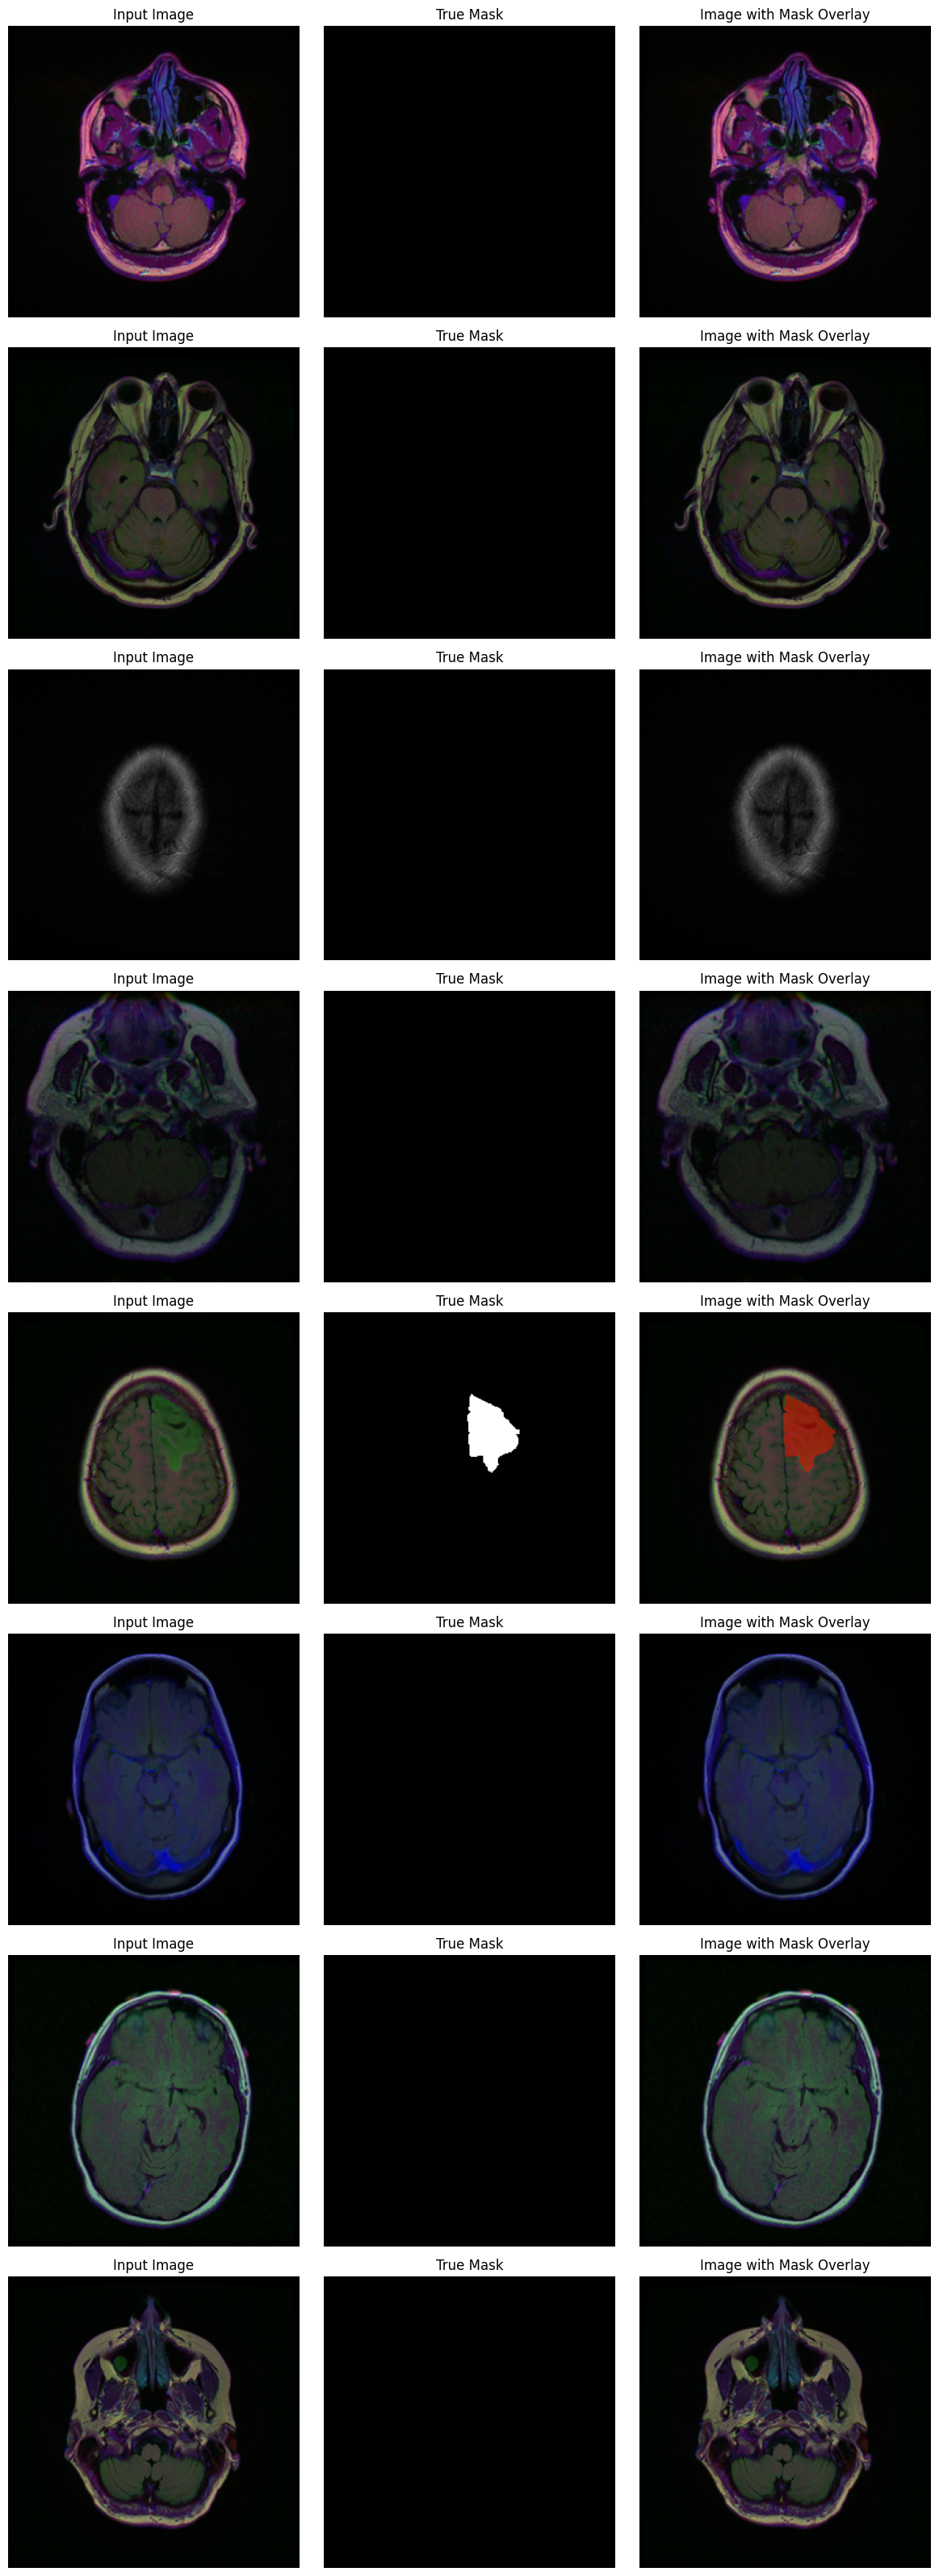

In [11]:

def display_sample(display_list):
    plt.figure(figsize=(12, 4 * len(display_list[0])))
    
    for i in range(len(display_list[0])):
        plt.subplot(len(display_list[0]), 3, i*3 + 1)
        plt.title('Input Image')
        plt.imshow(display_list[0][i])
        plt.axis('off')
        
        plt.subplot(len(display_list[0]), 3, i*3 + 2)
        plt.title('True Mask')
        plt.imshow(tf.squeeze(display_list[1][i]), cmap='gray')
        plt.axis('off')
        
        # Overlay mask on image
        plt.subplot(len(display_list[0]), 3, i*3 + 3)
        plt.title('Image with Mask Overlay')
        img = display_list[0][i].numpy()
        mask = tf.squeeze(display_list[1][i]).numpy()
        
        # Create RGB mask for overlay (red channel)
        mask_rgb = np.zeros_like(img)
        mask_rgb[:, :, 0] = mask * 1.0  # Red channel
        
        # Blend image with mask
        alpha = 0.5
        mask_3d = np.expand_dims(mask, axis=-1)  # Shape becomes (256, 256, 1)
        blended = alpha * mask_rgb + (1 - alpha * mask_3d) * img
        plt.imshow(blended)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
# Display samples from first batch
for images, masks in train_dataset.take(1):
    display_sample([images, masks])


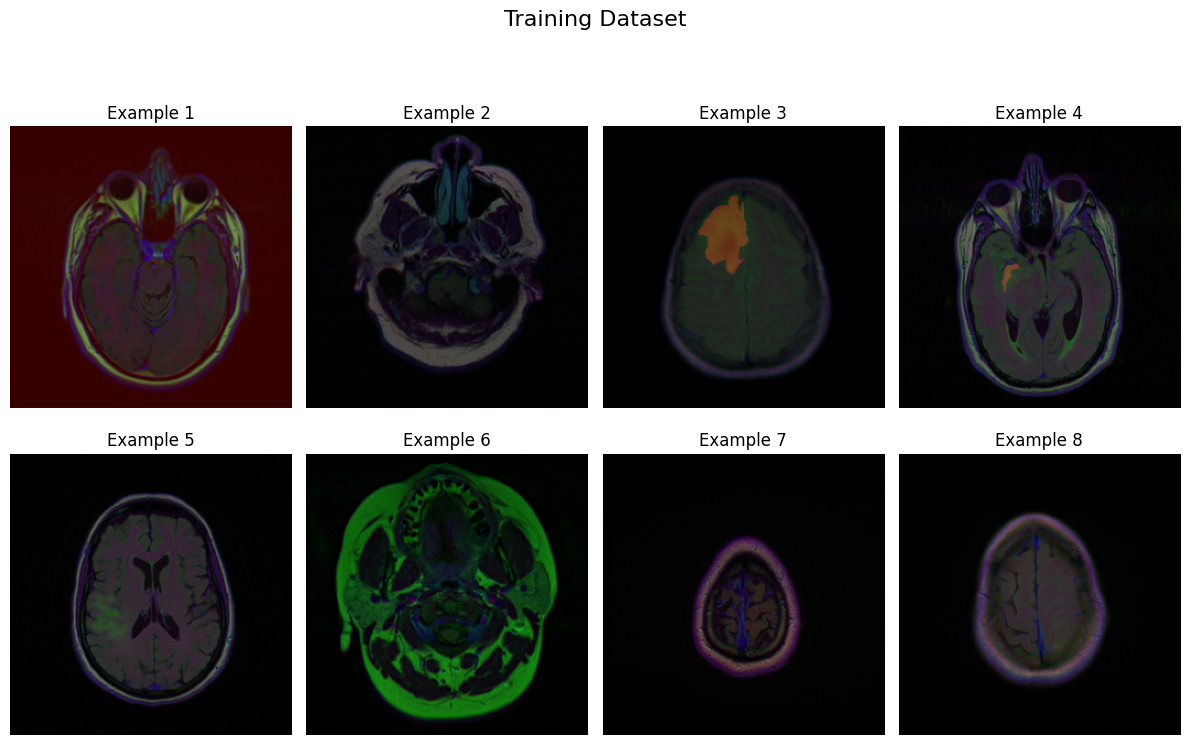

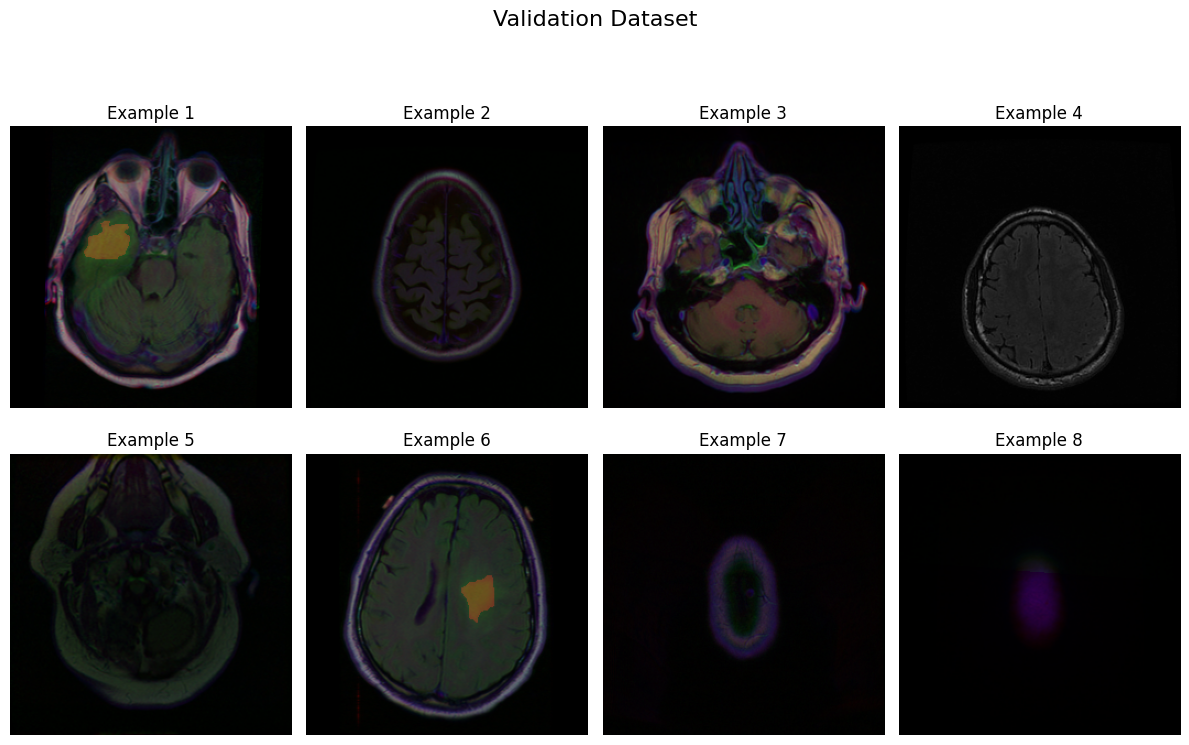

In [12]:

def display_batch(dataset, title="Dataset Batch"):
    plt.figure(figsize=(12, 8))
    plt.suptitle(title, fontsize=16)
    
    for images, masks in dataset.take(1):
        for i in range(min(8, len(images))):
            plt.subplot(2, 4, i+1)
            plt.imshow(images[i])
            
            # Overlay mask
            mask_overlay = np.zeros_like(images[i].numpy())
            mask_overlay[:, :, 0] = tf.squeeze(masks[i]).numpy()
            plt.imshow(mask_overlay, alpha=0.3)
            
            plt.title(f"Example {i+1}")
            plt.axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


display_batch(train_dataset, "Training Dataset")

display_batch(val_dataset, "Validation Dataset")

## Data Augmentation

In [13]:
def get_data_augmentation_model():
    """Create a data augmentation model to use during model training"""
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomFlip("vertical"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2)
    ])
    return data_augmentation

Creating training and validation datasets...

Visualizing augmentations...
Found 3929 image-mask pairs


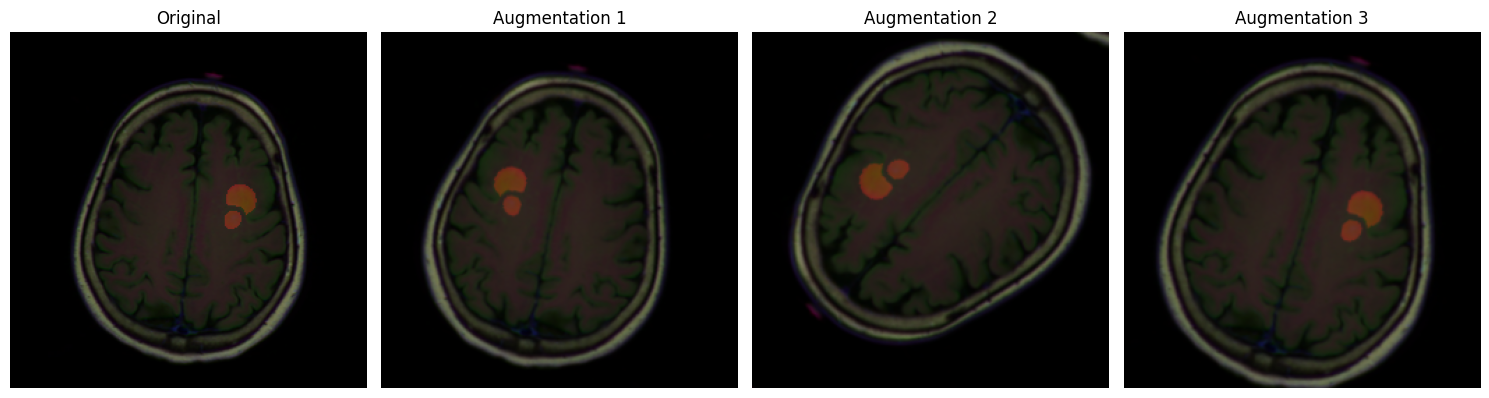

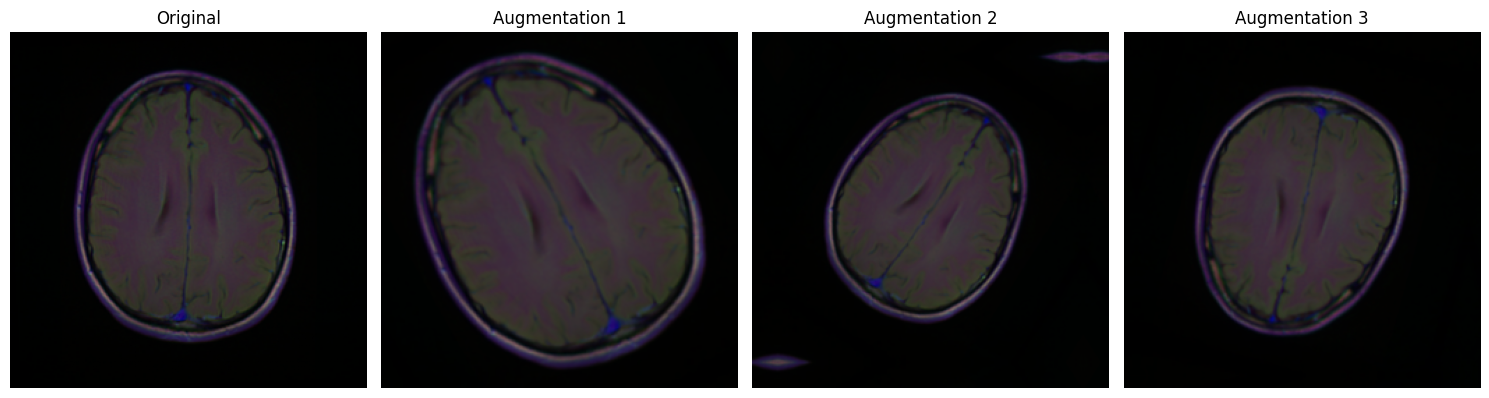

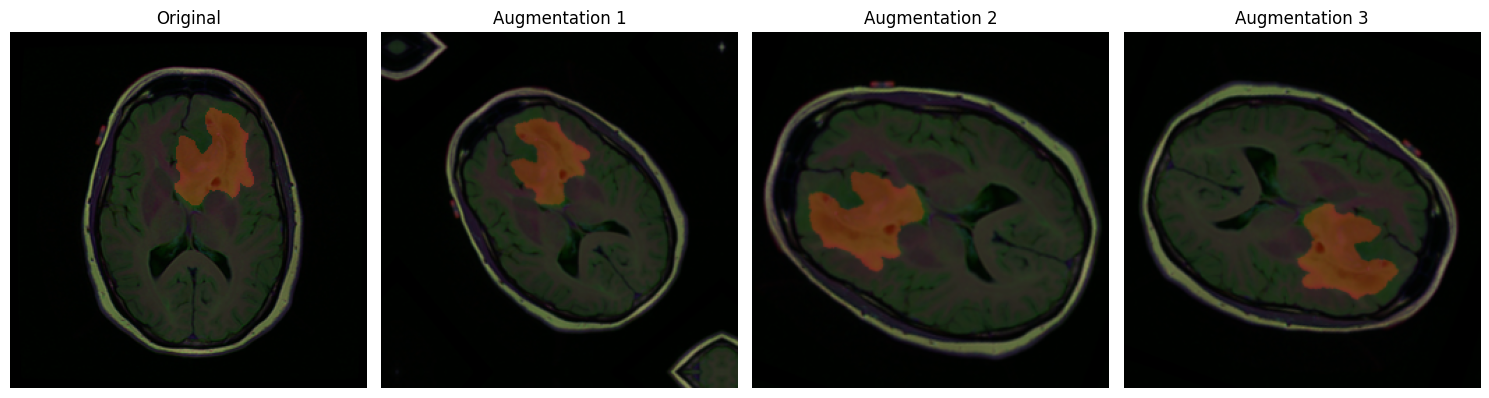

In [14]:
def visualize_simple_augmentations(num_examples=3):
    """Visualize augmentations using Keras preprocessing layers"""
    # Get augmentation model
    augmentation = get_data_augmentation_model()
    
    # Get some examples from dataset
    pairs = get_image_mask_pairs()
    if len(pairs) == 0:
        print("No image-mask pairs found!")
        return
    
    # Select random pairs
    selected_indices = np.random.choice(len(pairs), num_examples, replace=False)
    selected_pairs = [pairs[i] for i in selected_indices]
    
    for img_path, mask_path in selected_pairs:
        # Load original image and mask
        img = np.array(Image.open(img_path)) / 255.0
        mask = np.array(Image.open(mask_path)) / 255.0
        
        # Make sure mask has proper dimensions
        if len(mask.shape) > 2:
            mask = mask[:, :, 0]
        mask = mask[:, :, np.newaxis]
        
        # Convert to tensors
        img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
        mask_tensor = tf.convert_to_tensor(mask, dtype=tf.float32)
        
        # Combine for visualization (same transformations)
        combined = tf.concat([img_tensor, mask_tensor], axis=-1)
        
        # Display original and augmentations
        plt.figure(figsize=(15, 4))
        
        # Original
        plt.subplot(1, 4, 1)
        plt.imshow(img)
        
        # Overlay mask
        mask_overlay = np.zeros_like(img)
        mask_overlay[:, :, 0] = mask[:, :, 0]
        plt.imshow(mask_overlay, alpha=0.3)
        plt.title("Original")
        plt.axis('off')
        
        # Show 3 different augmentations
        for i in range(3):
            # Apply augmentation to combined image+mask
            augmented = augmentation(combined, training=True)
            
            # Split back
            aug_img = augmented[:, :, :3]
            aug_mask = augmented[:, :, 3:]
            
            # Display
            plt.subplot(1, 4, i+2)
            plt.imshow(aug_img)
            
            # Overlay mask
            mask_overlay = np.zeros_like(aug_img.numpy())
            mask_overlay[:, :, 0] = aug_mask[:, :, 0].numpy()
            plt.imshow(mask_overlay, alpha=0.3)
            plt.title(f"Augmentation {i+1}")
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()

# Create datasets with train/val split
print("Creating training and validation datasets...")


# Visualize augmentations separately
print("\nVisualizing augmentations...")
visualize_simple_augmentations(num_examples=3)

## Unet

### Loss Function: Dice Loss

<img src="https://www.mdpi.com/electronics/electronics-09-01199/article_deploy/html/images/electronics-09-01199-g0A1-550.jpg" alt="Training History" width="800"/>


In [15]:
def weighted_dice_loss(y_true, y_pred):
    """Weighted Dice loss for highly imbalanced segmentation"""
    # Weight the positive class (tumor) much more heavily
    pos_weight = 20.0  # Adjust based on class imbalance
    
    # Add a small epsilon to avoid division by zero
    smooth = 1e-5
    
    # Flatten predictions and ground truth
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    
    # Apply class weighting
    weight_mask = y_true_f * (pos_weight - 1.0) + 1.0
    
    # Calculate weighted intersection and union
    weighted_intersection = tf.reduce_sum(weight_mask * y_true_f * y_pred_f)
    weighted_union = tf.reduce_sum(weight_mask * y_true_f) + tf.reduce_sum(y_pred_f)
    
    # Calculate Dice coefficient
    dice = (2. * weighted_intersection + smooth) / (weighted_union + smooth)
    
    # Return Dice loss
    return 1 - dice

### Unet Model
<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" alt="Training History" width="900"/>

In [16]:
def create_unet_model():
    """Create a standard-sized U-Net model with batch normalization"""
    with strategy.scope():
        # Input layer
        inputs = tf.keras.layers.Input(shape=(256, 256, 3))
        
        # Data augmentation (only applied during training)
        data_augmentation = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomFlip("vertical"),
            tf.keras.layers.RandomRotation(0.2),
            tf.keras.layers.RandomZoom(0.2)
        ])
        
        # Apply augmentation
        x = data_augmentation(inputs)
        
        # Encoder Path
        # Block 1
        conv1 = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
        conv1 = tf.keras.layers.BatchNormalization()(conv1)
        conv1 = tf.keras.layers.Activation('relu')(conv1)
        conv1 = tf.keras.layers.Conv2D(64, 3, padding='same')(conv1)
        conv1 = tf.keras.layers.BatchNormalization()(conv1)
        conv1 = tf.keras.layers.Activation('relu')(conv1)
        pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
        
        # Block 2
        conv2 = tf.keras.layers.Conv2D(128, 3, padding='same')(pool1)
        conv2 = tf.keras.layers.BatchNormalization()(conv2)
        conv2 = tf.keras.layers.Activation('relu')(conv2)
        conv2 = tf.keras.layers.Conv2D(128, 3, padding='same')(conv2)
        conv2 = tf.keras.layers.BatchNormalization()(conv2)
        conv2 = tf.keras.layers.Activation('relu')(conv2)
        pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
        
        # Block 3
        conv3 = tf.keras.layers.Conv2D(256, 3, padding='same')(pool2)
        conv3 = tf.keras.layers.BatchNormalization()(conv3)
        conv3 = tf.keras.layers.Activation('relu')(conv3)
        conv3 = tf.keras.layers.Conv2D(256, 3, padding='same')(conv3)
        conv3 = tf.keras.layers.BatchNormalization()(conv3)
        conv3 = tf.keras.layers.Activation('relu')(conv3)
        pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
        
        # Block 4
        conv4 = tf.keras.layers.Conv2D(512, 3, padding='same')(pool3)
        conv4 = tf.keras.layers.BatchNormalization()(conv4)
        conv4 = tf.keras.layers.Activation('relu')(conv4)
        conv4 = tf.keras.layers.Conv2D(512, 3, padding='same')(conv4)
        conv4 = tf.keras.layers.BatchNormalization()(conv4)
        conv4 = tf.keras.layers.Activation('relu')(conv4)
        drop4 = tf.keras.layers.Dropout(0.5)(conv4)
        pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(drop4)
        
        # Bridge
        conv5 = tf.keras.layers.Conv2D(1024, 3, padding='same')(pool4)
        conv5 = tf.keras.layers.BatchNormalization()(conv5)
        conv5 = tf.keras.layers.Activation('relu')(conv5)
        conv5 = tf.keras.layers.Conv2D(1024, 3, padding='same')(conv5)
        conv5 = tf.keras.layers.BatchNormalization()(conv5)
        conv5 = tf.keras.layers.Activation('relu')(conv5)
        drop5 = tf.keras.layers.Dropout(0.5)(conv5)
        
        # Decoder Path
        # Block 6
        up6 = tf.keras.layers.Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(drop5)
        concat6 = tf.keras.layers.Concatenate(axis=3)([drop4, up6])
        conv6 = tf.keras.layers.Conv2D(512, 3, padding='same')(concat6)
        conv6 = tf.keras.layers.BatchNormalization()(conv6)
        conv6 = tf.keras.layers.Activation('relu')(conv6)
        conv6 = tf.keras.layers.Conv2D(512, 3, padding='same')(conv6)
        conv6 = tf.keras.layers.BatchNormalization()(conv6)
        conv6 = tf.keras.layers.Activation('relu')(conv6)
        
        # Block 7
        up7 = tf.keras.layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
        concat7 = tf.keras.layers.Concatenate(axis=3)([conv3, up7])
        conv7 = tf.keras.layers.Conv2D(256, 3, padding='same')(concat7)
        conv7 = tf.keras.layers.BatchNormalization()(conv7)
        conv7 = tf.keras.layers.Activation('relu')(conv7)
        conv7 = tf.keras.layers.Conv2D(256, 3, padding='same')(conv7)
        conv7 = tf.keras.layers.BatchNormalization()(conv7)
        conv7 = tf.keras.layers.Activation('relu')(conv7)
        
        # Block 8
        up8 = tf.keras.layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
        concat8 = tf.keras.layers.Concatenate(axis=3)([conv2, up8])
        conv8 = tf.keras.layers.Conv2D(128, 3, padding='same')(concat8)
        conv8 = tf.keras.layers.BatchNormalization()(conv8)
        conv8 = tf.keras.layers.Activation('relu')(conv8)
        conv8 = tf.keras.layers.Conv2D(128, 3, padding='same')(conv8)
        conv8 = tf.keras.layers.BatchNormalization()(conv8)
        conv8 = tf.keras.layers.Activation('relu')(conv8)
        
        # Block 9
        up9 = tf.keras.layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
        concat9 = tf.keras.layers.Concatenate(axis=3)([conv1, up9])
        conv9 = tf.keras.layers.Conv2D(64, 3, padding='same')(concat9)
        conv9 = tf.keras.layers.BatchNormalization()(conv9)
        conv9 = tf.keras.layers.Activation('relu')(conv9)
        conv9 = tf.keras.layers.Conv2D(64, 3, padding='same')(conv9)
        conv9 = tf.keras.layers.BatchNormalization()(conv9)
        conv9 = tf.keras.layers.Activation('relu')(conv9)
        
        # Output layer
        outputs = tf.keras.layers.Conv2D(1, 1, activation='sigmoid')(conv9)
        
        # Create model
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        
        # Compile model with weighted dice loss
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            loss=weighted_dice_loss,  # Use weighted dice loss for better results
            metrics=[
                'accuracy',
                tf.keras.metrics.IoU(
                    num_classes=2,
                    target_class_ids=[1],
                    name='iou'
                ),
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')
            ]
        )
        
        return model

In [17]:

def train_model(model, train_dataset, val_dataset, epochs=50):
    # Create callbacks
    callbacks = [
        # Reduce learning rate when plateauing
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-6,
            verbose=1
        ),
    ]
    
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=callbacks
    )
    
    return history, model

In [18]:

count_train = 0
count_val = 0
for _ in train_dataset:
    count_train += 1
for _ in val_dataset:
    count_val += 1
print(f"Training dataset: {count_train} batches of size {BATCH_SIZE}")
print(f"Validation dataset: {count_val} batches of size {BATCH_SIZE}")


model = create_unet_model()
model.summary()



Training dataset: 392 batches of size 16
Validation dataset: 98 batches of size 16


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_1 (Sequential) │ (None, 256, 256, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ sequential_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 128)  │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 128, 128, 128)  │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 128)  │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 128, 128, 128)  │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

## Train

In [19]:
history, trained_model = train_model(
    model=model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    epochs=25
)


Epoch 1/25
392/392 ━━━━━━━━━━━━━━━━━━━━ 215s 483ms/step - accuracy: 0.7606 - iou: 0.0021 - loss: 0.4309 - precision: 0.0385 - recall: 0.8788 - val_accuracy: 0.0632 - val_iou: 0.0284 - val_loss: 0.6808 - val_precision: 0.0107 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/25
392/392 ━━━━━━━━━━━━━━━━━━━━ 190s 484ms/step - accuracy: 0.8452 - iou: 0.0178 - loss: 0.2962 - precision: 0.0542 - recall: 0.8550 - val_accuracy: 0.8871 - val_iou: 0.0083 - val_loss: 0.1295 - val_precision: 0.0786 - val_recall: 0.9473 - learning_rate: 1.0000e-04
Epoch 3/25
392/392 ━━━━━━━━━━━━━━━━━━━━ 189s 483ms/step - accuracy: 0.8495 - iou: 0.0246 - loss: 0.2743 - precision: 0.0558 - recall: 0.8677 - val_accuracy: 0.9011 - val_iou: 0.0011 - val_loss: 0.1935 - val_precision: 0.0809 - val_recall: 0.8468 - learning_rate: 1.0000e-04
Epoch 4/25
392/392 ━━━━━━━━━━━━━━━━━━━━ 189s 482ms/step - accuracy: 0.8583 - iou: 0.0343 - loss: 0.2419 - precision: 0.0598 - recall: 0.8457 - val_accuracy: 0.9424 - val_iou: 0.0

## Evaluation

### Visualize Training History

In [20]:

def visualize_training_history(history):
    """Plot training history metrics"""
    plt.figure(figsize=(16, 6))
    
    # Plot loss
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot IoU
    plt.subplot(1, 3, 2)
    plt.plot(history.history['iou'], label='Training IoU')
    plt.plot(history.history['val_iou'], label='Validation IoU')
    plt.title('Intersection over Union (IoU)')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()
    
    # Plot Precision and Recall
    plt.subplot(1, 3, 3)
    plt.plot(history.history['precision'], label='Training Precision')
    plt.plot(history.history['val_precision'], label='Validation Precision')
    plt.plot(history.history['recall'], label='Training Recall')
    plt.plot(history.history['val_recall'], label='Validation Recall')
    plt.title('Precision and Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()
    
    plt.tight_layout()
    plt.show()



### Visualize Predictions against ground truth labels

In [21]:
def visualize_predictions(model, dataset, num_examples=5):
    """Visualize model predictions compared to ground truth with improved display"""
    # Get a batch from the dataset
    images = None
    masks = None
    
    # Get the first batch
    for img_batch, mask_batch in dataset.take(1):
        images = img_batch
        masks = mask_batch
        break
    
    if images is None or masks is None:
        print("ERROR: Could not get images and masks from dataset")
        return
    
    # Make predictions
    predictions = model.predict(images)
    
    # Print information about prediction values
    print(f"Prediction stats: min={np.min(predictions):.6f}, max={np.max(predictions):.6f}, mean={np.mean(predictions):.6f}")
    print(f"Mask stats: min={np.min(masks.numpy()):.6f}, max={np.max(masks.numpy()):.6f}, mean={np.mean(masks.numpy()):.6f}")
    
    # Display results
    plt.figure(figsize=(15, 5 * min(num_examples, len(images))))
    
    for i in range(min(num_examples, len(images))):
        # Display original image
        plt.subplot(num_examples, 3, i*3 + 1)
        plt.imshow(images[i])
        plt.title(f"Original Image {i+1}")
        plt.axis('off')
        
        # Display ground truth mask
        plt.subplot(num_examples, 3, i*3 + 2)
        mask_display = tf.squeeze(masks[i]).numpy()
        plt.imshow(mask_display, cmap='viridis')
        plt.title(f"True Mask (sum={np.sum(mask_display):.1f})")
        plt.axis('off')
        
        # Display predicted mask
        plt.subplot(num_examples, 3, i*3 + 3)
        pred_display = tf.squeeze(predictions[i]).numpy()
        plt.imshow(pred_display, cmap='viridis')  # Viridis shows small values better than gray
        plt.title(f"Predicted Mask (sum={np.sum(pred_display):.1f})")
        plt.axis('off')
        
        # Add a colorbar
        plt.colorbar(fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()
    
    # Display overlayed predictions for better comparison
    plt.figure(figsize=(15, 5 * min(num_examples, len(images))))
    
    for i in range(min(num_examples, len(images))):
        # Original image
        plt.subplot(num_examples, 2, i*2 + 1)
        plt.imshow(images[i])
        
        # Overlay ground truth mask in red
        mask_overlay = np.zeros_like(images[i].numpy())
        mask_overlay[:, :, 0] = tf.squeeze(masks[i]).numpy() * 1.0  # Red channel
        plt.imshow(mask_overlay, alpha=0.5)
        plt.title(f"Image {i+1} with True Mask")
        plt.axis('off')
        
        # Original image again
        plt.subplot(num_examples, 2, i*2 + 2)
        plt.imshow(images[i])
        
        # Overlay predicted mask in blue
        pred_overlay = np.zeros_like(images[i].numpy())
        pred_overlay[:, :, 2] = tf.squeeze(predictions[i]).numpy() * 1.0  # Blue channel
        plt.imshow(pred_overlay, alpha=0.5)
        plt.title(f"Image {i+1} with Predicted Mask")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # If predictions are too low, show a thresholded version
    if np.max(predictions) < 0.1:
        print("WARNING: Predictions have very low values. Showing amplified visualization...")
        
        plt.figure(figsize=(15, 5 * min(num_examples, len(images))))
        
        for i in range(min(num_examples, len(images))):
            # Original image
            plt.subplot(num_examples, 2, i*2 + 1)
            plt.imshow(images[i])
            plt.title(f"Original Image {i+1}")
            plt.axis('off')
            
            # Amplified prediction
            plt.subplot(num_examples, 2, i*2 + 2)
            # Normalize predictions to [0,1] range for better visualization
            pred_norm = tf.squeeze(predictions[i]).numpy()
            if np.max(pred_norm) > 0:
                pred_norm = pred_norm / np.max(pred_norm)
            plt.imshow(pred_norm, cmap='hot')
            plt.colorbar(fraction=0.046, pad=0.04)
            plt.title(f"Amplified Prediction (max actual value: {np.max(predictions[i]):.6f})")
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()

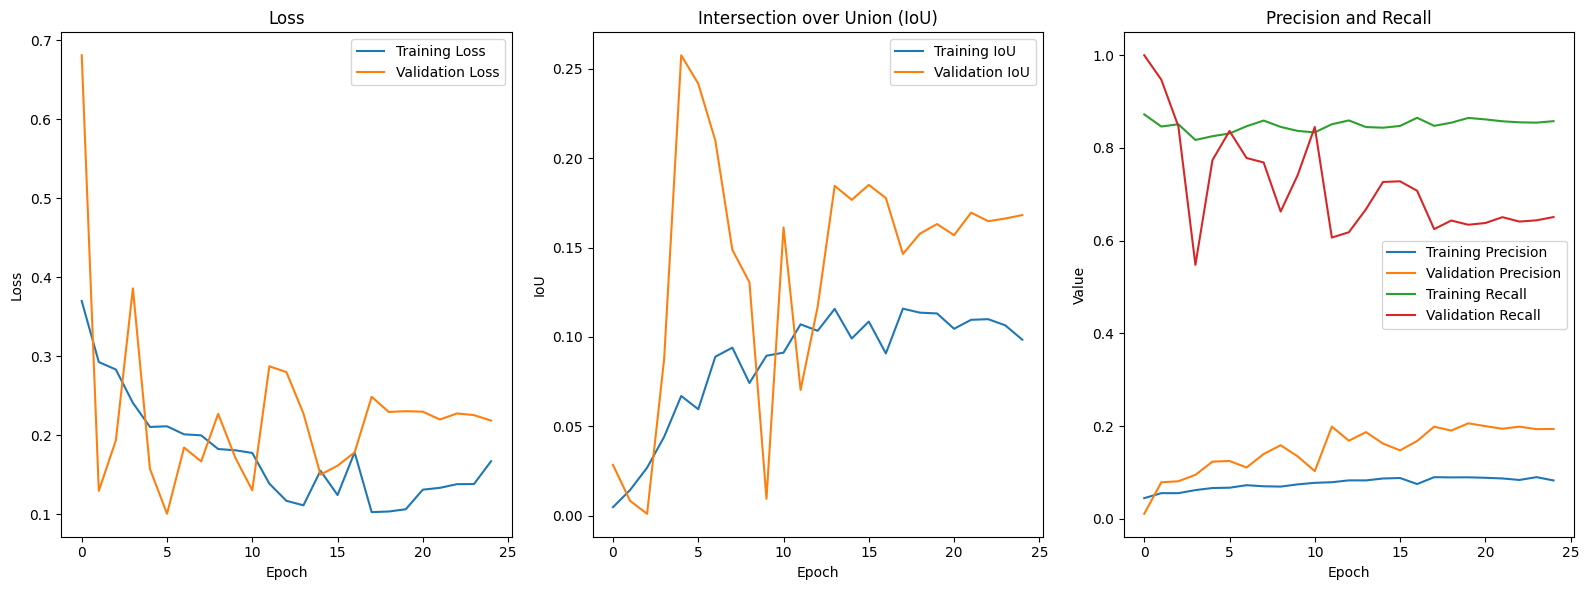

In [22]:
visualize_training_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
Prediction stats: min=0.000077, max=1.000000, mean=0.040823
Mask stats: min=0.000000, max=1.000000, mean=0.003481


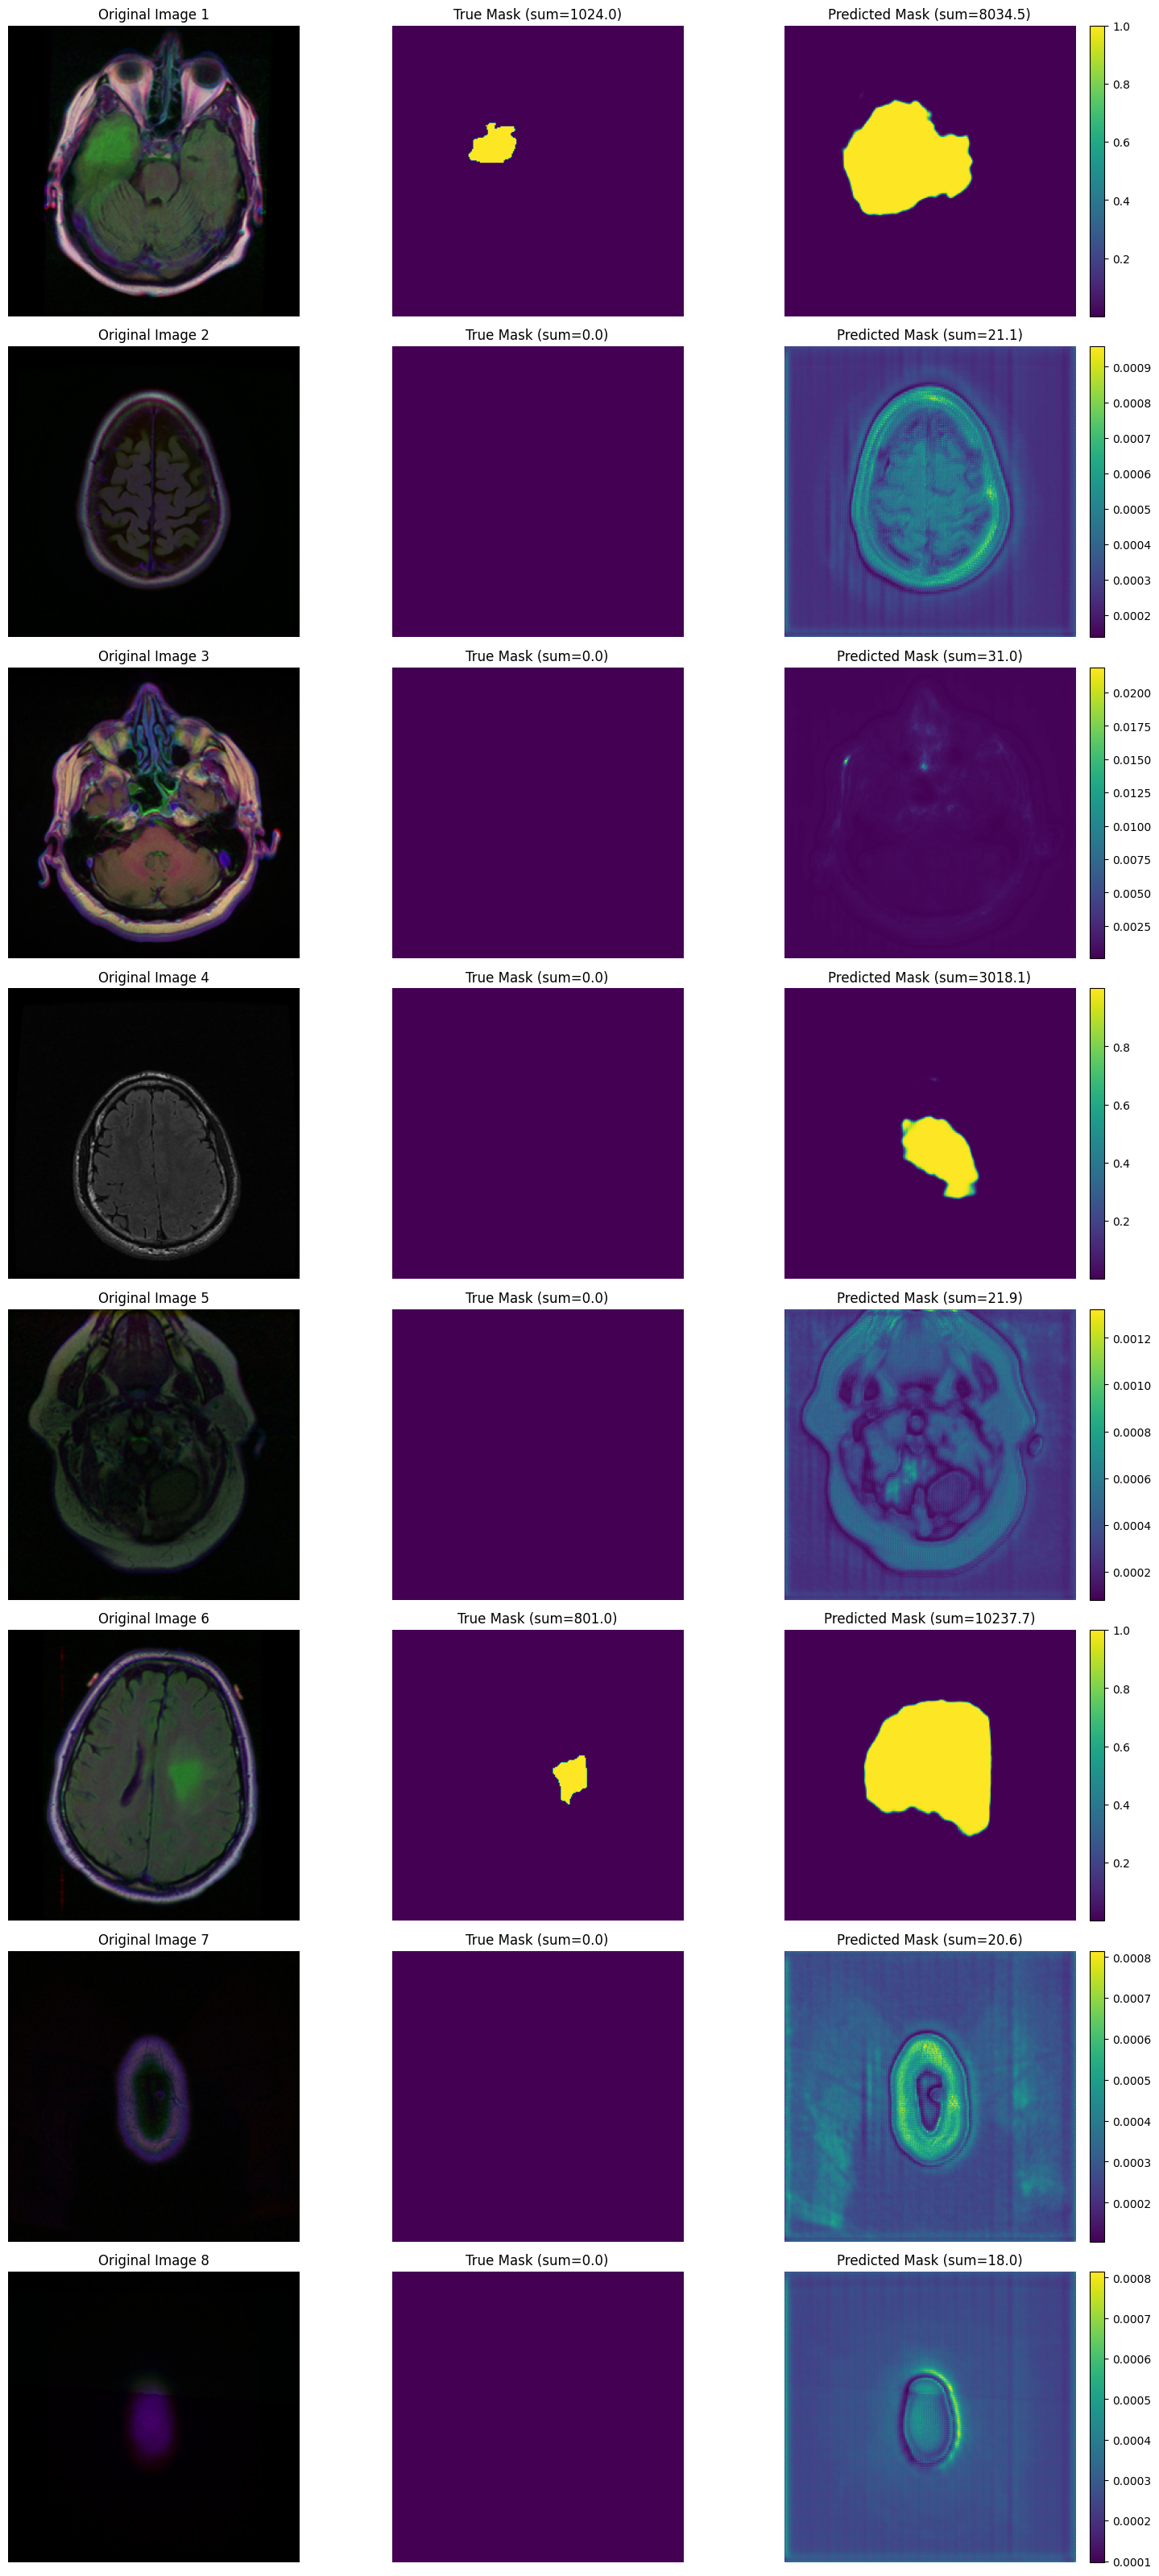

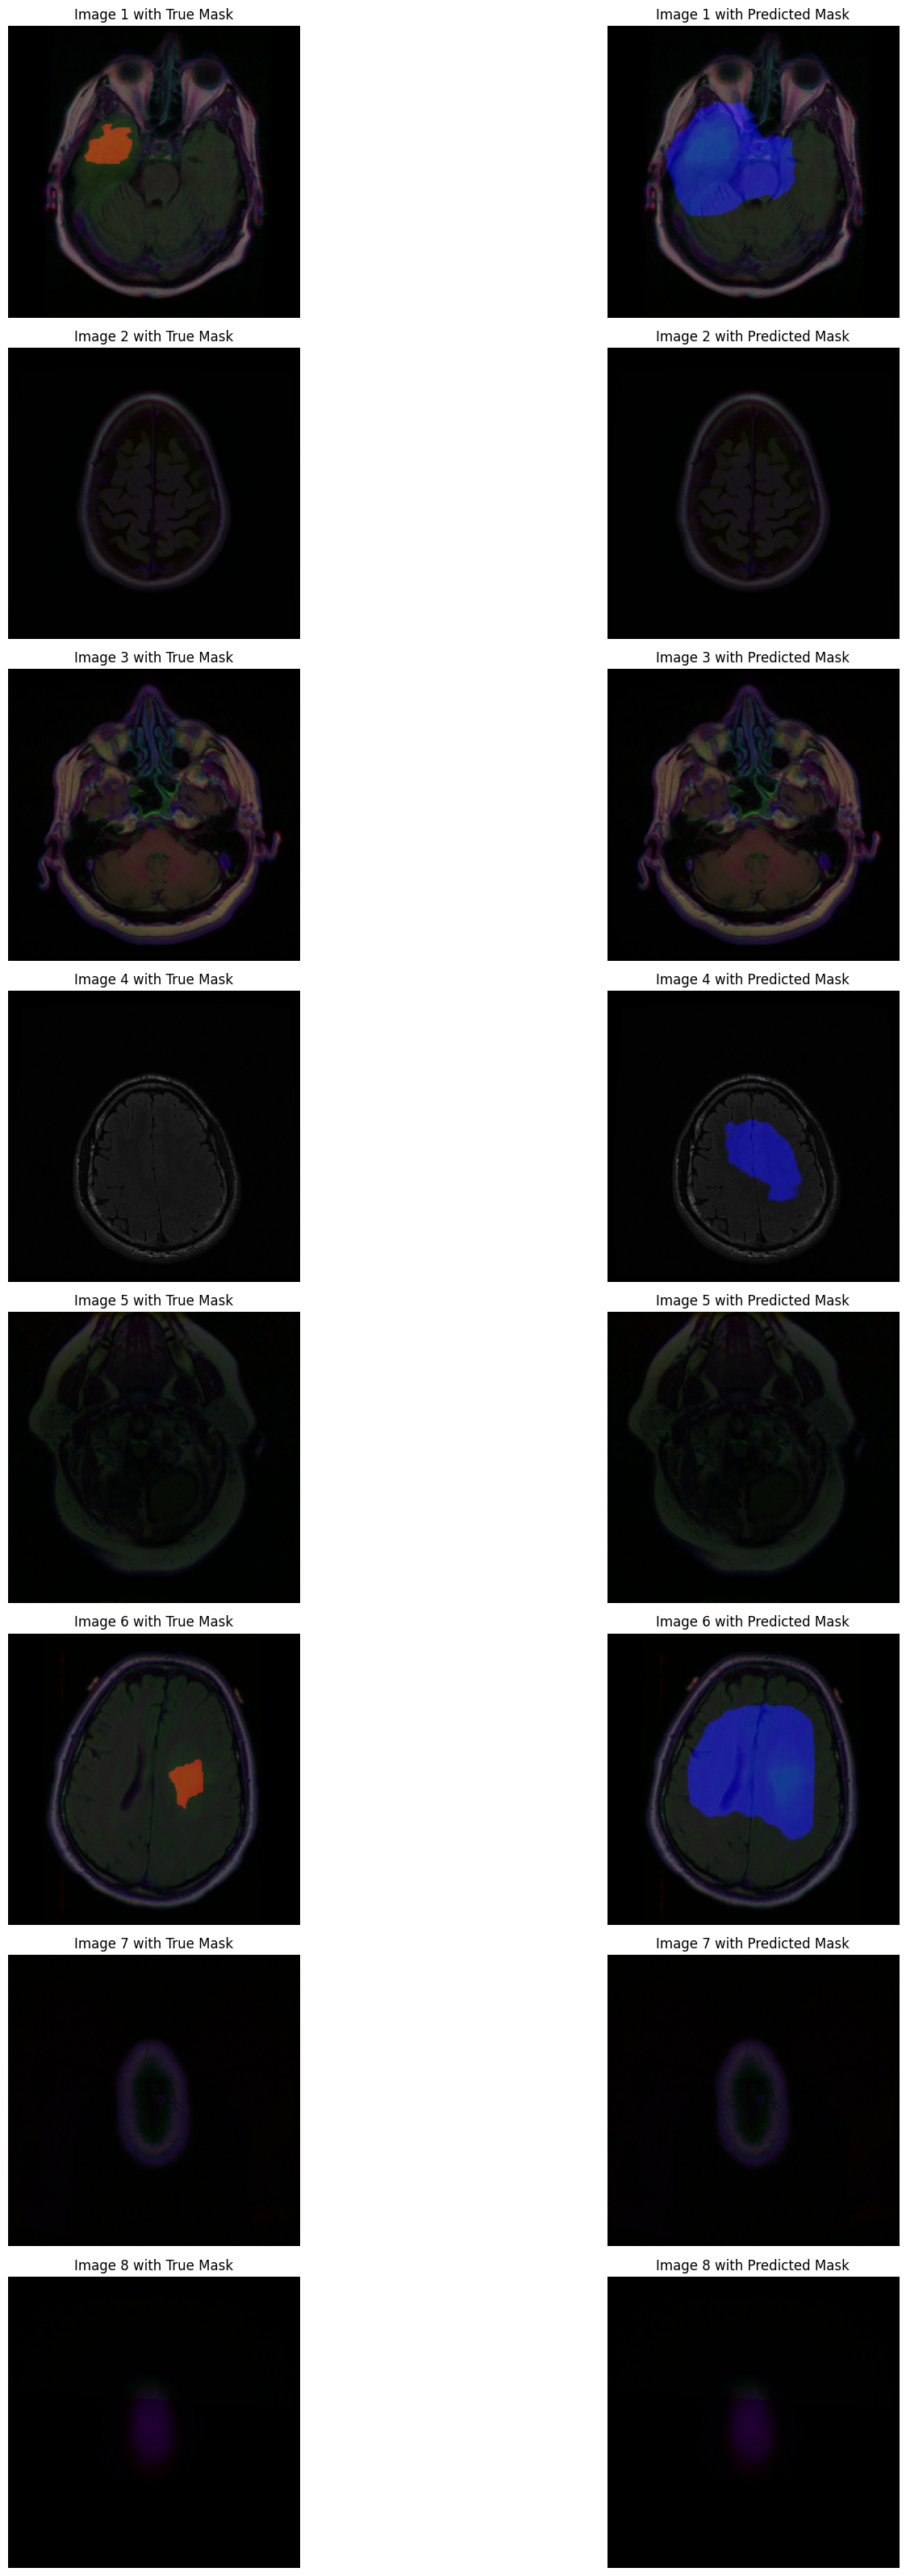

In [24]:
visualize_predictions(model, val_dataset, num_examples=10)